# Weekly Rushing Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.fantasy_football_v2.data.generate_dataframes.generate_rusher_df import generate_rusher_df
from src.fantasy_football_v2.data.generate_dataframes.generate_weekly_points_df import generate_weekly_points_df

from src.fantasy_football_v2.utilities.get_stats import get_summary_stats

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
# Get last year data since we only have last year fantasy points
rusher_df = generate_rusher_df([2024])
rusher_df.shape

(580, 11)

In [4]:
rusher_df.head()

,season,week,player_gsis_id,player_display_name,player_position,team_abbr,efficiency,rush_attempts,rush_yards,avg_rush_yards,rush_touchdowns
4810,2024,0,00-0035700,Josh Jacobs,RB,GB,3.563792,301,1329,4.415282,15
4811,2024,0,00-0038120,Breece Hall,RB,NYJ,4.289543,209,876,4.191388,5
4812,2024,0,00-0036997,Javonte Williams,RB,DEN,4.040273,139,513,3.690647,4
4813,2024,0,00-0037840,Kyren Williams,RB,LAR,3.764627,316,1299,4.110759,14
4814,2024,0,00-0036275,D'Andre Swift,RB,CHI,4.501449,253,959,3.790514,6


In [5]:
weekly_points_df = generate_weekly_points_df([2024])
weekly_points_df.head()

Downcasting floats.


,season,week,player_id,player_display_name,recent_team,position,fantasy_points_ppr,game_id
0,2024,1,00-0023459,Aaron Rodgers,NYJ,QB,8.580000,2024_01_NYJ_SF
1,2024,2,00-0023459,Aaron Rodgers,NYJ,QB,15.140000,2024_02_NYJ_TEN
2,2024,3,00-0023459,Aaron Rodgers,NYJ,QB,21.040001,2024_03_NE_NYJ
3,2024,4,00-0023459,Aaron Rodgers,NYJ,QB,11.600000,2024_04_DEN_NYJ
4,2024,5,00-0023459,Aaron Rodgers,NYJ,QB,11.760000,2024_05_NYJ_MIN


In [6]:
# merge fantasy points into passer data
rusher_df_pts = rusher_df.merge(
    weekly_points_df[[
        'season',
        'week',
        'player_id',
        'fantasy_points_ppr'
    ]],
    left_on=['season', 'week', 'player_gsis_id'],
    right_on=['season', 'week', 'player_id'],
    how='left'
)

rusher_df_pts.shape

(580, 13)

In [7]:
rusher_df_pts.head()

,season,week,player_gsis_id,player_display_name,player_position,team_abbr,efficiency,rush_attempts,rush_yards,avg_rush_yards,rush_touchdowns,player_id,fantasy_points_ppr
0,2024,0,00-0035700,Josh Jacobs,RB,GB,3.563792,301,1329,4.415282,15,NaN,NaN
1,2024,0,00-0038120,Breece Hall,RB,NYJ,4.289543,209,876,4.191388,5,NaN,NaN
2,2024,0,00-0036997,Javonte Williams,RB,DEN,4.040273,139,513,3.690647,4,NaN,NaN
3,2024,0,00-0037840,Kyren Williams,RB,LAR,3.764627,316,1299,4.110759,14,NaN,NaN
4,2024,0,00-0036275,D'Andre Swift,RB,CHI,4.501449,253,959,3.790514,6,NaN,NaN


In [8]:
rusher_df_pts['week'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [9]:
df = rusher_df_pts[
    (rusher_df_pts['season'] == 2024) &
    (rusher_df_pts['week'] == 1) &
    (rusher_df_pts['player_display_name'] == 'Breece Hall')
]

df.head()

,season,week,player_gsis_id,player_display_name,player_position,team_abbr,efficiency,rush_attempts,rush_yards,avg_rush_yards,rush_touchdowns,player_id,fantasy_points_ppr
48,2024,1,00-0038120,Breece Hall,RB,NYJ,4.849074,16,54,3.375,1,00-0038120,18.299999


# Correlation Matrix

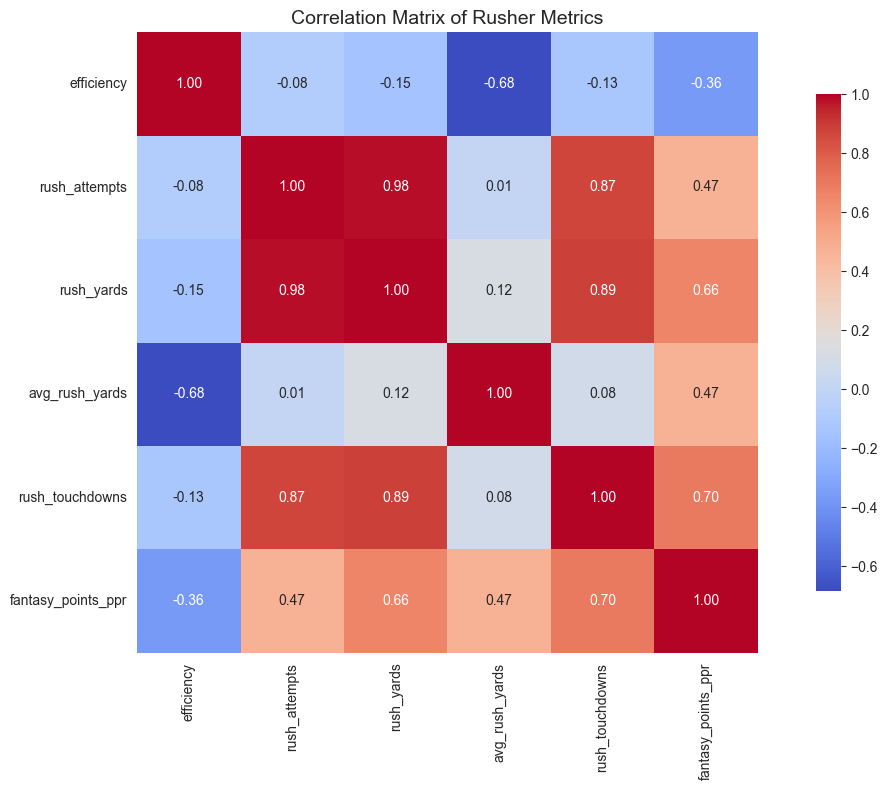

In [10]:
# Correlation Matrix
# select numerical column only
metrics_df = rusher_df_pts.select_dtypes(include=[np.number])
metrics_df.drop(['season', 'week'], axis=1, inplace=True)

# Create the correlation matrix
corr_matrix = metrics_df.corr()

# Plot correlation matrix as a heat map
plt.figure(
    figsize = (12, 8)
)
sns.heatmap(
    corr_matrix,
    annot=True, # Shows correlation values in cells
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={'shrink': 0.8} # Makes colorbar smaller
)
plt.title("Correlation Matrix of Rusher Metrics", fontsize=14)
plt.tight_layout()
plt.show()

Rushing touchdowns are most closely related to fantasy points, followed by rushing yards.

### Group Players by Rushing Yards and Rushing Touchdowns

1. High Yards, High Touchdowns
2. High Yards, Low Touchdowns
3. Low Yards, High Touchdowns
4. Low Yards, Low Touchdowns

In [11]:
# Group by player and take average passer_rating and pass_touchdowns
df = (
    rusher_df_pts.groupby('player_display_name', as_index=False)
        .agg({
            'rush_yards': 'mean',
            'rush_touchdowns': 'mean',
    })
)

# Calculate the overall averages
avg_rating = rusher_df_pts['rush_yards'].mean()
avg_passing_tds = rusher_df_pts['rush_touchdowns'].mean()

# Define the conditions
conditions = [
    (df['rush_yards'] > avg_rating) & (df['rush_touchdowns'] > avg_passing_tds),
    (df['rush_yards'] > avg_rating) & (df['rush_touchdowns'] <= avg_passing_tds),
    (df['rush_yards'] <= avg_rating) & (df['rush_touchdowns'] > avg_passing_tds),
    (df['rush_yards'] <= avg_rating) & (df['rush_touchdowns'] <= avg_passing_tds)
]

# 3️⃣ Define the corresponding group labels
groups = [
    "High Yards / High TDs",
    "High Yards / Low TDs",
    "Low Yards / High TDs",
    "Low Yards / Low TDs"
]

# Create a new column for group
df['performance_group'] = np.select(conditions, groups)

# View players by group
df = (df.groupby('performance_group', group_keys=False)
    .apply(lambda x: x[['performance_group', 'player_display_name', 'rush_yards', 'rush_touchdowns']])
    .reset_index(drop=True)
)

df = df.sort_values(
    by=['performance_group', 'rush_yards', 'rush_touchdowns'],
    ascending=[True, False, False]
)

# Remove player with a low rating and low td's
df = df[
    df['performance_group'] != 'Low Yards / Low TDs'
]

print(df.shape)
df.head(100)

(37, 4)


,performance_group,player_display_name,rush_yards,rush_touchdowns
26,High Yards / High TDs,Devon Achane,907.000000,6.000000
80,High Yards / High TDs,Tyrone Tracy,839.000000,5.000000
52,High Yards / High TDs,Kenneth Walker,573.000000,7.000000
68,High Yards / High TDs,Saquon Barkley,235.882353,1.529412
24,High Yards / High TDs,Derrick Henry,213.444444,1.777778
11,High Yards / High TDs,Bucky Irving,195.200000,1.500000
45,High Yards / High TDs,Jonathan Taylor,190.800000,1.466667
7,High Yards / High TDs,Bijan Robinson,169.647059,1.647059
27,High Yards / High TDs,Emanuel Wilson,169.250000,1.500000
35,High Yards / High TDs,Jahmyr Gibbs,169.125000,1.937500
